# Определение возраста покупателей

## Исследовательский анализ данных

In [21]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [22]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [23]:
labels.shape

(7591, 2)

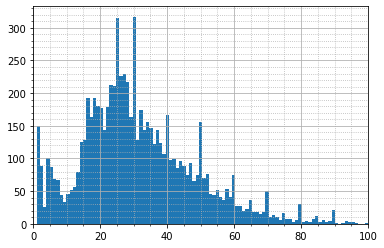

In [25]:
plt.hist(labels['real_age'], bins=100)
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.minorticks_on()
plt.xlim([0., 100.])

plt.show()

In [26]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

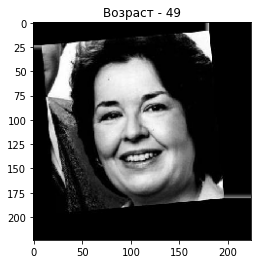

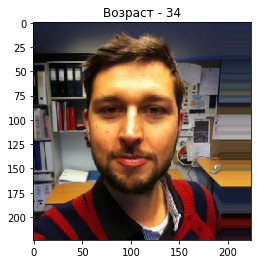

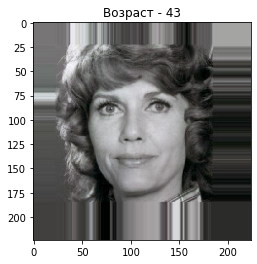

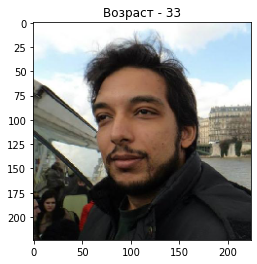

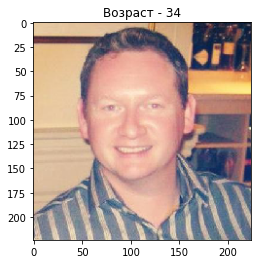

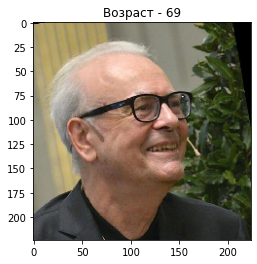

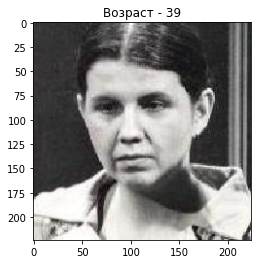

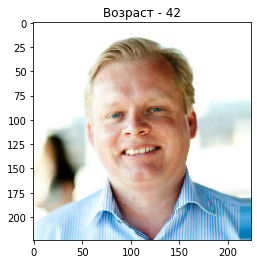

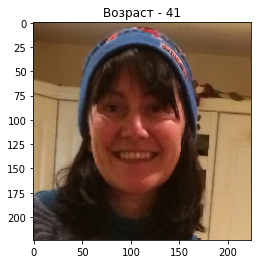

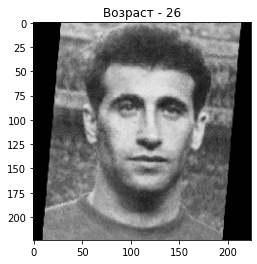

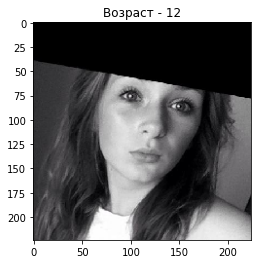

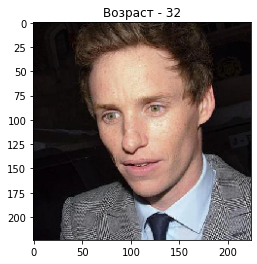

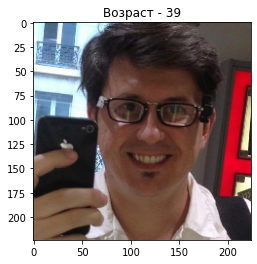

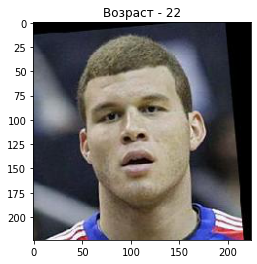

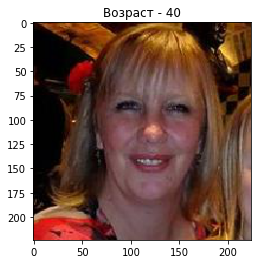

In [27]:
x,y = train_gen_flow.next()
for i in range(0,15):
    image = x[i]
    plt.imshow(image)
    plt.title(f'Возраст - {y[i]}')
    plt.show()

## Вывод 

<div class="alert alert-info"> 
Размер датасета 7591 фотографий, данных не много , буду использовать горизонтальную аугментацию в тестовой выборке.
    
Основная часть фото сделана в промежутке от 15 до 4о лет. Большая часть фото соотвествует какой то круглой дате или юбилею,  что может свидетельствовать о не очень качественной разметки части данных. 
    
Фото есть черно-белые и цветные. На фото есть посторонние предметы, обрезнанные фотографии, лица сделаны крупным планом  или размыты. Фото многие сделаны не в профиль, видно только половина лица. Мимика на фото всегда разная.
    

</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw',
        subset='training', 
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

 
def create_model(input_shape):
    backbone = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        input_shape=input_shape, 
        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
    
    
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-07-13 20:59:24.743789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-13 20:59:25.043361: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 207.2944 - mae: 10.8997 - val_loss: 294.9797 - val_mae: 12.9594
Epoch 2/20
356/356 - 40s - loss: 135.5341 - mae: 8.9148 - val_loss: 241.0989 - val_mae: 11.8296
Epoch 3/20
356/356 - 40s - loss: 111.4245 - mae: 8.0154 - val_loss: 111.3217 - val_mae: 8.0384
Epoch 4/20
356/356 - 39s - loss: 91.7267 - mae: 7.3349 - val_loss: 232.7278 - val_mae: 11.1488
Epoch 5/20
356/356 - 40s - loss: 80.2222 - mae: 6.8583 - val_loss: 104.6975 - val_mae: 7.6428
Epoch 6/20
356/356 - 39s - loss: 63.1462 - mae: 6.1378 - val_loss: 102.8794 - val_mae: 7.8176
Epoch 7/20
356/356 - 40s - loss: 57.7354 - mae: 5.8378 - val_loss: 158.3775 - val_mae: 9.4909
Epoch 8/20
356/356 - 40s - loss: 49.4025 - mae: 5.4087 - val_loss: 98.4274 - val_mae: 7.6430
Epoch 9/20
356/356 - 39s - loss: 42.1969 - mae: 5.0004 - val_loss: 98.9456 - val_mae: 7.8038
Epoch 10/20
356/356 - 40s - loss: 37.6126 - mae: 4.7288 - val_loss: 94.7876 - val_mae: 7.2235
Epoch 11/20
356/356 - 40s - loss: 32.5864 - mae: 4.3838 - val_loss: 97.6961 - val_mae: 7.6559
Epoch 12/20
356/356 - 40s - loss: 28.3776 - mae: 4.1024 - val_loss: 106.3989 - val_mae: 7.5618
Epoch 13/20
356/356 - 40s - loss: 26.4970 - mae: 3.9333 - val_loss: 90.6164 - val_mae: 7.0316
Epoch 14/20
356/356 - 40s - loss: 22.9842 - mae: 3.6925 - val_loss: 83.6624 - val_mae: 6.9803
Epoch 15/20
356/356 - 40s - loss: 20.5039 - mae: 3.4819 - val_loss: 132.0411 - val_mae: 8.7174
Epoch 16/20
356/356 - 40s - loss: 20.2543 - mae: 3.4469 - val_loss: 89.1154 - val_mae: 7.2286
Epoch 17/20
356/356 - 40s - loss: 19.6694 - mae: 3.4140 - val_loss: 91.8171 - val_mae: 7.4006
Epoch 18/20
356/356 - 39s - loss: 18.3760 - mae: 3.3092 - val_loss: 95.8528 - val_mae: 7.2373
Epoch 19/20
356/356 - 39s - loss: 17.2763 - mae: 3.2130 - val_loss: 93.9044 - val_mae: 7.3729
Epoch 20/20
356/356 - 40s - loss: 19.0609 - mae: 3.3532 - val_loss: 92.2987 - val_mae: 7.4196
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 92.2987 - mae: 7.4196
Test MAE: 7.4196

```

## Анализ обученной модели

<div class="alert alert-info">
    
 - Для оптимизации использовал алгоритм Adam, со скоростью обучения (learning rate = 0.0005)
    
 - Провел обучение модели с помощью архитектуры ResNet50.
    
 - В ImageDataGenerator в обучающей выборке добавил  аугментацию отражения по вертикали (horizontal_flip=True). 
    
 - В загрузке данных batch_size равен 16


В результате показатель mae = 7.4196.

Было запущено 20 эпох. После 15 эпохи точность модел падает, модель переобучается.
    </div>